# Doc2Vec for speech2019 similiarity_without_GPE_new
|
by pg9349

This code is for generating speech embeddings and clustering using various techniques and storing results of DBscan clutering into a json file to be used for topic modelling

In [1]:
from gensim.models import Doc2Vec
import smart_open
from gensim.models.doc2vec import TaggedDocument

In [2]:
import multiprocessing
from tqdm import tqdm
cores = multiprocessing.cpu_count()

In [3]:
import numpy as np

In [4]:
import pandas as pd
df=pd.read_json("un_speeches_tokenised.json",orient='records',compression='infer')

In [5]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country',
       'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split',
       'word_split', 'count_speech_words', 'count_speech_sent'],
      dtype='object')

### Getting the respective years speech

In [6]:
speech19=df[df['Year']==2019.0]


In [7]:
usa19=speech19[speech19['ISO Code']=='USA']['doc'].values
alb19=speech19[speech19['ISO Code']=='ALB']['doc'].values
cuba19=speech19[speech19['ISO Code']=='CUB']['doc'].values
ven19=speech19[speech19['ISO Code']=='VEN']['doc'].values

In [8]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

### Analysing speeches for Cross reference of other nations in speeches

In [9]:
text1= NER(str(usa19))
displacy.render(text1,style="ent",jupyter=True)

In [10]:
text1= NER(str(alb19))
displacy.render(text1,style="ent",jupyter=True)

In [11]:
text1= NER(str(cuba19))
displacy.render(text1,style="ent",jupyter=True)

In [12]:
text1= NER(str(ven19))
displacy.render(text1,style="ent",jupyter=True)

In [9]:
countries=set()
for i in speech19['doc']:
    text= NER(str(i))
    for word in text.ents:
        country,gpe=word.text,word.label_
        if gpe=="GPE":
            countries.add(country)
       
    

### Removing GPEs

In [10]:
countries
def removegpe(x):
    l=[]
    for i in x:
        if i not in countries:
            l.append(i)
    return l
            

In [11]:
speech19['word_split_withoutgpe']=speech19['word_split'].apply(removegpe)

<ipython-input-11-ac26de496abb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech19['word_split_withoutgpe']=speech19['word_split'].apply(removegpe)


In [12]:
for i in speech19['word_split'][:10]:
    print(len(i))

2251
1396
2709
2571
1900
1873
2717
4060
2783
1530


In [13]:
for i in speech19['word_split_withoutgpe'][:10]:
    print(len(i))

2218
1373
2639
2561
1866
1848
2657
3997
2716
1499


In [14]:
doc19=speech19['word_split_withoutgpe']

### Creating Tagged Documents for Doc2Vec model

In [15]:
# train_tagged = TaggedDocument(words=doc19, tags=[i for i in range(len(doc19))])
# # train_tagged = train.apply(
# #     lambda r: TaggedDocument(words=tokenize_text(r['description']), tags=[r.issue]), axis=1)
i=0
train_tagged = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc19)]

In [16]:
train_tagged

[TaggedDocument(words=['It', 'is', 'an', 'honour', 'for', 'me', 'to', 'and', 'stand', 'at', 'this', 'prestigious', 'rostrum', 'today', 'to', 'represent', 'my', 'fellow', 'countrywomen', 'and', 'men', 'and', 'address', 'distinguished', 'colleagues', 'and', 'partners', 'in', 'the', 'General', 'Assembly', '.', 'I', 'am', 'even', 'more', 'proud', 'today', 'because', 'just', 'two', 'days', 'ago', ',', 'approximately', '3', 'million', 'Afghans', ',', 'facing', 'the', 'threat', 'of', 'terrorism', ',', 'risked', 'their', 'lives', 'to', 'vote', 'in', 'our', 'young', 'democracy', '’', 's', 'fourth', 'presidential', 'election', '.', 'Those', 'who', 'voted', 'included', 'men', 'and', 'women', ',', 'the', 'very', 'elderly', ',', 'some', 'voting', 'for', 'perhaps', 'the', 'last', 'time', ',', 'and', 'the', 'very', 'young', ',', 'those', 'voting', 'for', 'the', 'very', 'first', 'of', 'many', 'times', ',', 'as', 'well', 'as', 'those', 'living', 'with', 'a', 'disability', ',', 'for', 'whom', 'the', 'jo

In [75]:

# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow = Doc2Vec(seed=42,dm=0, vector_size=50, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow

In [76]:

# model_dbow.build_vocab(train_tagged)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 195153.73it/s]


In [77]:

from sklearn import utils
for epoch in range(30):
    model_dbow.train([x for x in tqdm(train_tagged)], total_examples=len(train_tagged), epochs=1)
#     model_dbow.alpha -= 0.002
#     model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<?, ?it/s]


In [23]:
model_dbow.save("doc2vec_new_without_gpe_2019.model")

### Load the saved model

In [24]:

model = Doc2Vec.load("doc2vec_new_without_gpe_2019.model")

### Getting Vector Embeddings

In [59]:

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    model.random.seed(42)
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [60]:
_, X_train = vec_for_learning(model, train_tagged)

In [61]:
X_train=np.array(X_train)

In [29]:
X_train[0]

array([ 1.3771024 , -0.174712  ,  0.50879544, -0.10020922, -1.0217916 ,
       -0.91545403, -0.71352625,  1.4252743 , -0.0198599 , -0.302862  ,
       -1.4262552 ,  1.6070861 , -1.5044961 ,  0.2381762 ,  0.00240042,
        0.29485318,  1.2563056 ,  0.55044687, -1.0045946 , -0.25503463,
        0.31687534,  0.03173414, -0.8791428 , -0.18931466, -1.215087  ,
       -0.28967848,  0.6314077 , -0.18251708, -1.2099961 ,  0.3361572 ,
       -0.61826795, -0.40985176, -1.0824841 , -1.142987  , -0.666831  ,
        0.8618947 , -0.21686073,  0.8802106 ,  0.18662621,  0.05666559,
        0.39643273,  0.6858477 ,  0.33654353, -0.77073544,  0.5348089 ,
        0.11082151, -0.5301985 ,  0.3269686 ,  0.36513856, -1.4350879 ],
      dtype=float32)

# TSNE for dim reduction

In [224]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2,
                  random_state=42, perplexity=3).fit_transform(X_train)
X_embedded.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(195, 2)

In [239]:
viz=pd.DataFrame(X_embedded,columns=["dim1","dim2"])

In [226]:
speech19['ISO Code']

8094    AFG
8095    AGO
8096    ALB
8097    AND
8098    ARE
8099    ARG
8100    ARM
8101    ATG
8102    AUS
8103    AUT
8104    AZE
8105    BDI
8106    BEL
8107    BEN
8108    BFA
8109    BGD
8110    BGR
8111    BHR
8112    BHS
8113    BIH
8114    BLR
8115    BLZ
8116    BOL
8117    BRA
8118    BRB
8119    BRN
8120    BTN
8121    BWA
8122    CAF
8123    CAN
8124    CHE
8125    CHL
8126    CHN
8127    CIV
8128    CMR
8129    COD
8130    COG
8131    COL
8132    COM
8133    CPV
8134    CRI
8135    CUB
8136    CYP
8137    CZE
8138    DEU
8139    DJI
8140    DMA
8141    DNK
8142    DOM
8143    DZA
8144    ECU
8145    EGY
8146    ERI
8147    ESP
8148    EST
8149    ETH
8150     EU
8151    FIN
8152    FJI
8153    FRA
8154    FSM
8155    GAB
8156    GBR
8157    GEO
8158    GHA
8159    GIN
8160    GMB
8161    GNB
8162    GNQ
8163    GRC
8164    GRD
8165    GTM
8166    GUY
8167    HND
8168    HRV
8169    HTI
8170    HUN
8171    IDN
8172    IND
8173    IRL
8174    IRN
8175    IRQ
8176    ISL
8177

In [240]:
viz['country_code']=speech19['ISO Code'].values
viz['country']=speech19['Country'].values

In [241]:
viz.columns

Index(['dim1', 'dim2', 'country_code', 'country'], dtype='object')

In [168]:
viz

dim1       dim2 country_code                                            country
0   -18.581921  29.726879          AFG                                        Afghanistan
1     5.760216 -24.993082          AGO                                 Republic of Angola
2    -4.393172 -41.638535          ALB                                Republic of Albania
3     3.729962   1.877359          AND                            Principality of Andorra
4    17.848372  43.110558          ARE                               United Arab Emirates
5   -25.269945  -0.747559          ARG                                 Argentine Republic
6     4.402683 -10.905620          ARM                                Republic of Armenia
7    -8.904375 -36.507607          ATG                                Antigua and Barbuda
8   -24.721382  28.684330          AUS                          Commonwealth of Australia
9   -34.821629  -6.489073          AUT                                Republic of Austria
10   -6.857749 -45.188671          AZE                                         Azerbaijan
11    2.846030 -17.156404          BDI                                            Burundi
12   -1.813084 -29.674725          BEL                                 Kingdom of Belgium
13   14.562835 -13.915765          BEN                                              Benin
14   20.072237 -16.739681          BFA                                       Burkina Faso
15    0.261001 -21.841633          BGD                    People’s Republic of Bangladesh
16  -37.054729 -10.928474          BGR                               Republic of Bulgaria
17   33.888744  36.936996          BHR                                            Bahrain
18  -23.968727  16.526413          BHS                        Commonwealth of the Bahamas
19   35.420258  -4.474434          BIH                             Bosnia and Herzegovina
20  -20.502813 -35.861782          BLR                                Republic of Belarus
21  -27.828423  13.932799          BLZ                                             Belize
22    1.078921  -2.539033          BOL                     Plurinational State of Bolivia
23   -3.392886  18.433596          BRA                      Federative Republic of Brazil
24   -8.824257 -33.658199          BRB                                           Barbados
25   16.138603   6.084233          BRN                                  Brunei Darussalam
26   -3.852909  -6.501247          BTN                                             Bhutan
27    1.065404 -25.274837          BWA                                           Botswana
28  -11.078186 -23.297115          CAF                           Central African Republic
29  -42.059010  -5.404210          CAN                                             Canada
30  -29.616516   0.364213          CHE                                Swiss Confederation
31  -14.069429   4.512807          CHL                                  Republic of Chile
32  -37.852524  -7.848666          CHN                         People’s Republic of China
33   12.921164 -11.103662          CIV                          Republic of Côte d’Ivoire
34  -14.381218 -20.173237          CMR                               Republic of Cameroon
35   -5.177779  -3.221331          COD                   Democratic Republic of the Congo
36  -22.328583 -20.322498          COG                              Republic of the Congo
37   -5.764031  13.476460          COL                               Republic of Colombia
38  -30.146423  16.775366          COM                               Union of the Comoros
39    0.576843 -42.445320          CPV                             Republic of Cabo Verde
40   -2.311722   1.064355          CRI                             Republic of Costa Rica
41   -2.789960  13.984790          CUB                                               Cuba
42   26.706823  27.218275          CYP                                 Republic of Cyprus
43   18.447546  18.720821          CZE            

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
#         print(data[text_column][line])   
        p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

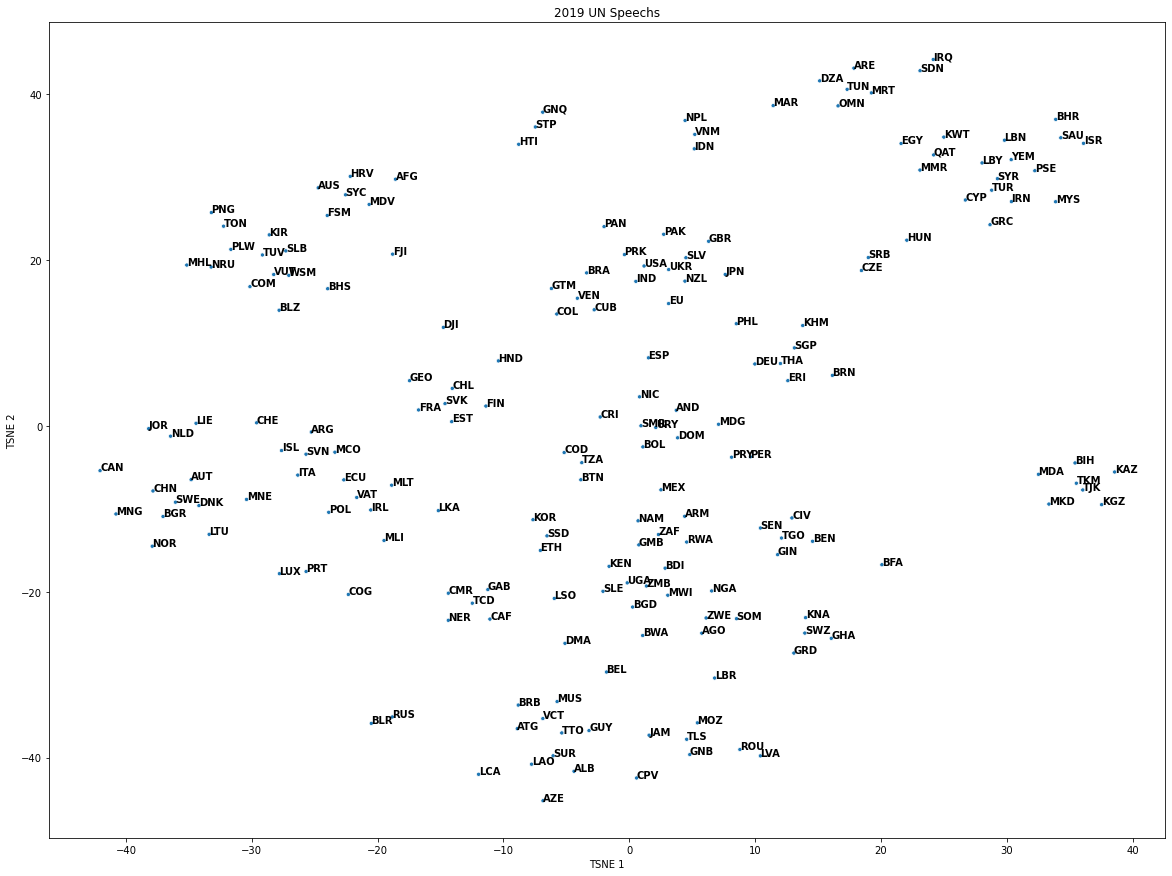

In [170]:
plt.figure(figsize=(20,15))
scatter_text('dim1', 'dim2', 'country_code',
             data = viz, 
             title = '2019 UN Speechs', 
             xlabel = 'TSNE 1',
             ylabel = 'TSNE 2')

In [171]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
speech19[['ISO Code','Country']].head(200)

ISO Code                                            Country
8094      AFG                                        Afghanistan
8095      AGO                                 Republic of Angola
8096      ALB                                Republic of Albania
8097      AND                            Principality of Andorra
8098      ARE                               United Arab Emirates
8099      ARG                                 Argentine Republic
8100      ARM                                Republic of Armenia
8101      ATG                                Antigua and Barbuda
8102      AUS                          Commonwealth of Australia
8103      AUT                                Republic of Austria
8104      AZE                                         Azerbaijan
8105      BDI                                            Burundi
8106      BEL                                 Kingdom of Belgium
8107      BEN                                              Benin
8108      BFA                                       Burkina Faso
8109      BGD                    People’s Republic of Bangladesh
8110      BGR                               Republic of Bulgaria
8111      BHR                                            Bahrain
8112      BHS                        Commonwealth of the Bahamas
8113      BIH                             Bosnia and Herzegovina
8114      BLR                                Republic of Belarus
8115      BLZ                                             Belize
8116      BOL                     Plurinational State of Bolivia
8117      BRA                      Federative Republic of Brazil
8118      BRB                                           Barbados
8119      BRN                                  Brunei Darussalam
8120      BTN                                             Bhutan
8121      BWA                                           Botswana
8122      CAF                           Central African Republic
8123      CAN                                             Canada
8124      CHE                                Swiss Confederation
8125      CHL                                  Republic of Chile
8126      CHN                         People’s Republic of China
8127      CIV                          Republic of Côte d’Ivoire
8128      CMR                               Republic of Cameroon
8129      COD                   Democratic Republic of the Congo
8130      COG                              Republic of the Congo
8131      COL                               Republic of Colombia
8132      COM                               Union of the Comoros
8133      CPV                             Republic of Cabo Verde
8134      CRI                             Republic of Costa Rica
8135      CUB                                               Cuba
8136      CYP                                 Republic of Cyprus
8137      CZE                                     Czech Republic
8138      DEU                        Federal Republic of Germany
8139      DJI                               Republic of Djibouti
8140      DMA                           Commonwealth of Dominica
8141      DNK                                            Denmark
8142      DOM                                 Dominican Republic
8143      DZA                                            Algeria
8144      ECU                                Republic of Ecuador
8145      EGY                             Arab Republic of Egypt
8146      ERI                                            Eritrea
8147      ESP                                   Kingdom of Spain
8148      EST                                Republic of Estonia
8149      ETH            Federal Democratic Republic of Ethiopia
8150       EU                                     European Union
8151      FIN                                Republic of Finland
8152      FJI                                   Republic of Fiji
8153      FRA                                    French Republic
8154      FSM                     Federa

In [172]:
import plotly.express as px

In [173]:
fig = px.scatter(viz, x="dim1", y="dim2",color="country",
                  hover_data=['country_code','country'],title="2019 UNGA speeches_without_GPE",text="country_code",width=1700,height=1200)
fig.show()

### Saving the plot

In [174]:
fig.write_html("speechs_2019_Without_GPE_new.html")

### Hierarchy clustering

In [175]:
import scipy.cluster.hierarchy as hac 

In [176]:
z = hac.linkage(viz[['dim1','dim2']], method='complete') 
labels = hac.fcluster(z, 1, criterion="distance")
labels = hac.fcluster(z, 30, criterion="distance")

In [177]:
labels

array([ 9,  5,  3,  6, 10,  1,  6,  3,  9,  1,  3,  4,  4,  5,  5,  4,  1,
       10,  9, 11,  3,  9,  6,  7,  3, 12,  6,  4,  2,  1,  1,  8,  1,  5,
        2,  6,  2,  7,  9,  4,  6,  7, 10, 12, 12,  8,  4,  1,  6, 10,  2,
       10, 12,  6,  8,  6,  7,  8,  9,  8,  9,  2,  7,  8,  5,  5,  6,  4,
        7, 10,  5,  7,  3,  8,  9,  7, 12,  7,  7,  2, 10, 10,  1, 10,  1,
        4,  1,  7, 11,  4, 11, 12,  9,  5,  6, 10,  3, 10,  5, 10,  3,  1,
        2,  4,  1,  2,  4, 10,  1, 11,  6,  9,  6,  9, 11,  2,  2, 10,  1,
        1,  4, 10,  3,  4, 10,  6,  2,  4,  6,  1,  1,  7,  9,  7, 10,  7,
        7,  6, 12,  9,  9,  2,  7,  2,  6, 10, 10,  4,  3,  6, 10, 10,  5,
       12,  9,  4,  7,  6,  5, 12,  6,  7,  3,  8,  1,  1,  5,  9, 10,  2,
        5, 12, 11, 11,  4,  9,  3, 10, 10,  9,  6,  4,  7,  6,  7,  2,  3,
        7,  7,  9,  9, 10,  6,  4,  5], dtype=int32)

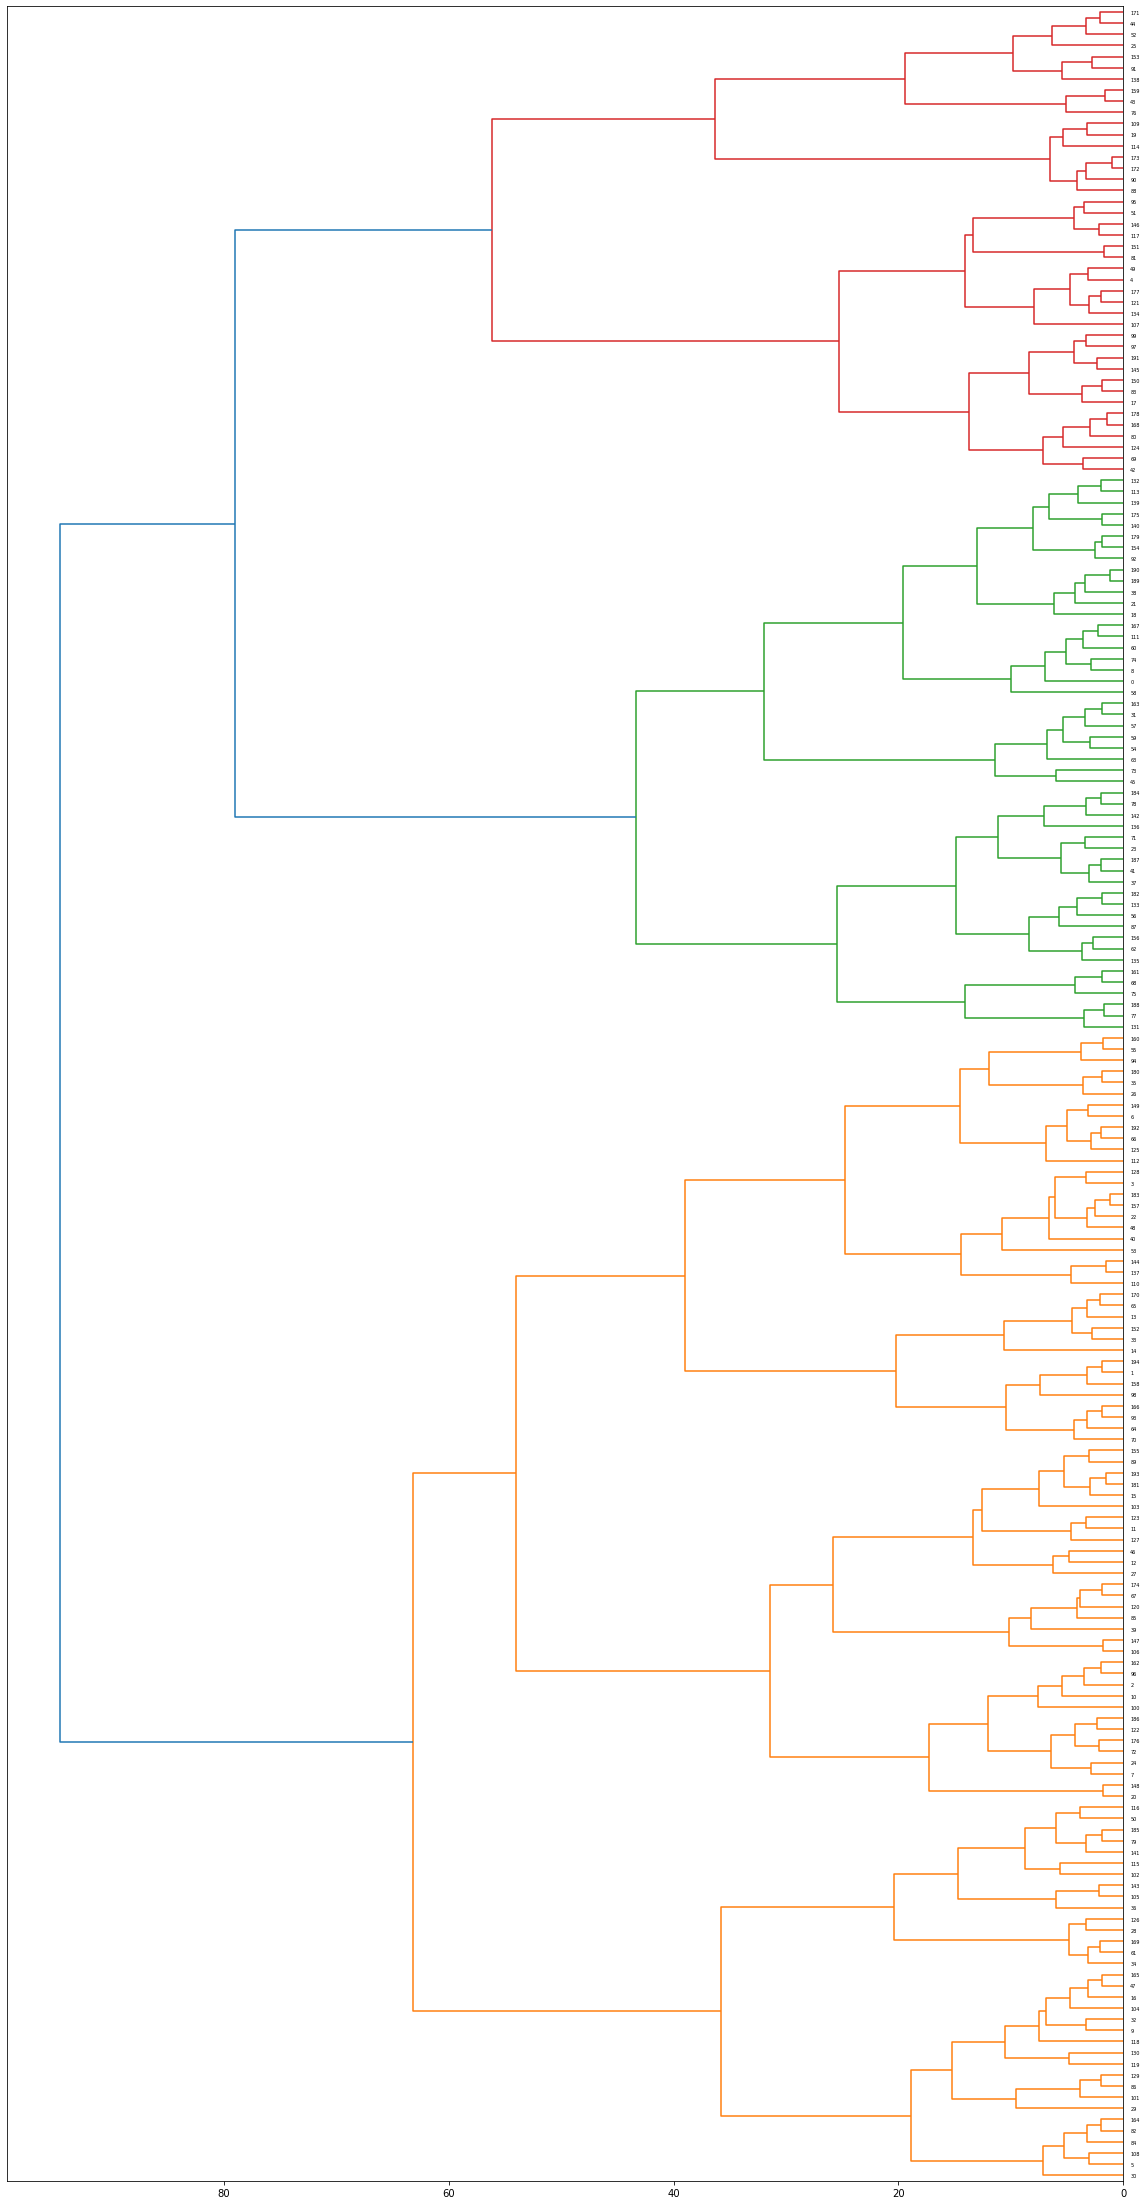

In [178]:
plt.figure(figsize=(20,40))
h=hac.dendrogram(z,orientation='left')
plt.show()

In [179]:
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [221]:
fig = px.scatter(viz, x="dim1", y="dim2",color="labels",

                  hover_data=['country_code','country'],title="2019 UNGA speeches without GPE hierarchy clustering",text="country_code",width=1700,height=1200)
fig.show()

### Plot after hierarchy cluster

In [181]:
fig.write_html("speechs_2019_Without_GPE_new_labels_dendogram.html")

### Clustering using KMeans

In [182]:
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Text(0, 0.5, 'Inertia')

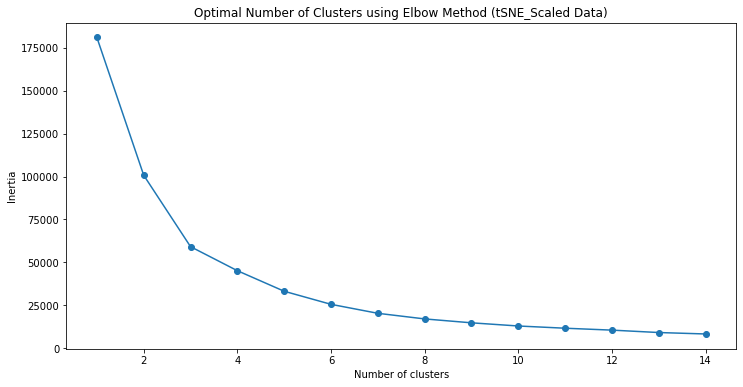

In [183]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(viz[['dim1','dim2']])
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [184]:
viz

dim1       dim2 country_code                                            country      labels
0   -18.581921  29.726879          AFG                                        Afghanistan   CLUSTER 9
1     5.760216 -24.993082          AGO                                 Republic of Angola   CLUSTER 5
2    -4.393172 -41.638535          ALB                                Republic of Albania   CLUSTER 3
3     3.729962   1.877359          AND                            Principality of Andorra   CLUSTER 6
4    17.848372  43.110558          ARE                               United Arab Emirates  CLUSTER 10
5   -25.269945  -0.747559          ARG                                 Argentine Republic   CLUSTER 1
6     4.402683 -10.905620          ARM                                Republic of Armenia   CLUSTER 6
7    -8.904375 -36.507607          ATG                                Antigua and Barbuda   CLUSTER 3
8   -24.721382  28.684330          AUS                          Commonwealth of Australia   CLUSTER 9
9   -34.821629  -6.489073          AUT                                Republic of Austria   CLUSTER 1
10   -6.857749 -45.188671          AZE                                         Azerbaijan   CLUSTER 3
11    2.846030 -17.156404          BDI                                            Burundi   CLUSTER 4
12   -1.813084 -29.674725          BEL                                 Kingdom of Belgium   CLUSTER 4
13   14.562835 -13.915765          BEN                                              Benin   CLUSTER 5
14   20.072237 -16.739681          BFA                                       Burkina Faso   CLUSTER 5
15    0.261001 -21.841633          BGD                    People’s Republic of Bangladesh   CLUSTER 4
16  -37.054729 -10.928474          BGR                               Republic of Bulgaria   CLUSTER 1
17   33.888744  36.936996          BHR                                            Bahrain  CLUSTER 10
18  -23.968727  16.526413          BHS                        Commonwealth of the Bahamas   CLUSTER 9
19   35.420258  -4.474434          BIH                             Bosnia and Herzegovina  CLUSTER 11
20  -20.502813 -35.861782          BLR                                Republic of Belarus   CLUSTER 3
21  -27.828423  13.932799          BLZ                                             Belize   CLUSTER 9
22    1.078921  -2.539033          BOL                     Plurinational State of Bolivia   CLUSTER 6
23   -3.392886  18.433596          BRA                      Federative Republic of Brazil   CLUSTER 7
24   -8.824257 -33.658199          BRB                                           Barbados   CLUSTER 3
25   16.138603   6.084233          BRN                                  Brunei Darussalam  CLUSTER 12
26   -3.852909  -6.501247          BTN                                             Bhutan   CLUSTER 6
27    1.065404 -25.274837          BWA                                           Botswana   CLUSTER 4
28  -11.078186 -23.297115          CAF                           Central African Republic   CLUSTER 2
29  -42.059010  -5.404210          CAN                                             Canada   CLUSTER 1
30  -29.616516   0.364213          CHE                                Swiss Confederation   CLUSTER 1
31  -14.069429   4.512807          CHL                                  Republic of Chile   CLUSTER 8
32  -37.852524  -7.848666          CHN                         People’s Republic of China   CLUSTER 1
33   12.921164 -11.103662          CIV                          Republic of Côte d’Ivoire   CLUSTER 5
34  -14.381218 -20.173237          CMR                               Republic of Cameroon   CLUSTER 2
35   -5.177779  -3.221331          COD                   Democratic Republic of the Congo   CLUSTER 6
36  -22.328583 -20.322498          COG                              Republic of the Congo   CLUSTER 2
37   -5.764031  13.476460          COL                               Republic of Colombia   CLUSTER 7
38  -30.146423  16.775366       

In [185]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(viz[['dim1','dim2']])
kmeans.labels_

labels=kmeans.predict(viz[['dim1','dim2']])
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [186]:

fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="2019 UNGA speeches_without GPE KMEANS CLUSTERS",text="country_code",width=1700,height=1200)
fig.show()

### Saving result

In [187]:
fig.write_html("speechs_2019_Without_GPE_new_labels_kmeans.html")

### Clustering using DBSCAN

In [242]:
from sklearn.cluster import DBSCAN
import numpy as np

clustering = DBSCAN(eps=5.5, min_samples=6).fit(viz[['dim1','dim2']])
labels=clustering.labels_

In [243]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [244]:
viz['labels']=labels
# viz=viz.sort_values('labels')
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Others" for i in viz['labels'] ]

In [246]:
fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                                  labels={
                     "dim1": "T SNE 1",
                     "dim2": "T SNE 2",
                     "labels": "Country Groups"
                 },
                  hover_data=['country_code','country'],title="2019 UNGA speeches without GPE Clusters",text="country_code",width=1700,height=1200)
fig.show()

### Saving results

In [247]:
fig.write_html("speechs_2019_Without_GPE_new_labels1.html")

In [248]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country', 'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split', 'word_split', 'count_speech_words', 'count_speech_sent'], dtype='object')

In [249]:
speech19['labels']=viz['labels'].values

<ipython-input-249-8f92495e96f9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [250]:
speech19.shape

(195, 15)

### Output file

In [251]:
speech19.to_json("un_speeches_2019_labels.json",orient='records',compression='infer')